## Importing dependencies

In [2]:
import numpy as np
import matplotlib.pyplot as plt
#import cv2
import sys
from PIL import Image
import PIL
import random
import copy
import seaborn as sns
import time



import torch
from torch import nn, optim
import torchvision
import torch.nn as nn
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader, random_split, Dataset, Subset

import torchvision.transforms.functional as Funct
import torch.nn.functional as F



from mpl_toolkits.axes_grid1 import ImageGrid


### Device agnostic code

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"

### Load dataset

In [4]:
class CIFAR10Data(Dataset):
    def __init__(self, cifar10_dir, train=True, transform=None):
        super(CIFAR10Data, self).__init__()
        self.dataset = CIFAR10(cifar10_dir, train=train, download=True, transform=transform)
        self.classes = self.dataset.classes


    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, index):
        image, label = self.dataset[index]
        return image, label

In [5]:
cifar10_dir = './dataset/CIFAR10'

transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.1,),(0.3,))
              ])



# Create CIFAR-10 train dataset
cifar10_train_data = CIFAR10Data(cifar10_dir, train=True, transform=transform)
print("Number of images in CIFAR-10 training dataset:", len(cifar10_train_data))

# Create CIFAR-10 test dataset
cifar10_test_data = CIFAR10Data(cifar10_dir, train=False, transform=transform)
print("Number of images in CIFAR-10 test dataset:", len(cifar10_test_data))


# Selecting  a subset from the original dataset
train_subset_size = 18000
small_train_set = torch.utils.data.Subset(cifar10_train_data, list(range(train_subset_size)))
train, valid = random_split(small_train_set,[16000,2000])

print("Number of images in train dataset:", len(train))


100%|███████████████████████████████████████████████████████████████| 170498071/170498071 [00:23<00:00, 7159379.20it/s]


Extracting ./dataset/CIFAR10\cifar-10-python.tar.gz to ./dataset/CIFAR10
Number of images in CIFAR-10 training dataset: 50000
Files already downloaded and verified
Number of images in CIFAR-10 test dataset: 10000
Number of images in train dataset: 16000


In [6]:
# Unpack the dataset in case you need it in the future
x_train,y_train = cifar10_train_data.dataset.data, np.array(cifar10_train_data.dataset.targets)
x_test, y_test = cifar10_test_data.dataset.data, np.array(cifar10_train_data.dataset.targets)

print("Image range before normalization is {}, {}".format(np.min(x_test, axis=(0, 1, 2, 3)), np.max(x_test, axis=(0, 1, 2, 3))))

# Normalize the images
x_train = (x_train / 255.).astype(np.float32)
x_test = (x_test / 255.).astype(np.float32)

# Print the image range before and after normalization
print("Image range after normalization is {}, {}".format(np.min(x_test, axis=(0, 1, 2, 3)), np.max(x_test, axis=(0, 1, 2, 3))))

Image range before normalization is 0, 255
Image range after normalization is 0.0, 1.0


### Data Visualization

In [7]:
def normalize_image(image):
    if isinstance(image, np.ndarray):
        image_min = image.min()
        image_max = image.max()
        image = np.clip(image, image_min, image_max)
        image = (image - image_min) / (image_max - image_min + 1e-6)
    elif isinstance(image, torch.Tensor):
        image_min = image.min()
        image_max = image.max()
        image.clamp_(min=image_min, max=image_max)
        image.add_(-image_min).div_(image_max - image_min + 1e-6)
    return image

def plot_images(images, labels, classes, normalize=True, rows=1, cols=5):
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 3, rows * 3))
    for i, ax in enumerate(axes.flat):
        image = images[i]
        if normalize:
            image = normalize_image(image)
        if isinstance(image, torch.Tensor):
            image = image.permute(1, 2, 0).cpu().numpy()
        ax.imshow(image)
        ax.set_title(classes[labels[i]])
        ax.axis('off')
    plt.tight_layout()
    plt.show()

In [8]:
images_without_labels = cifar10_train_data.dataset.data[:25]

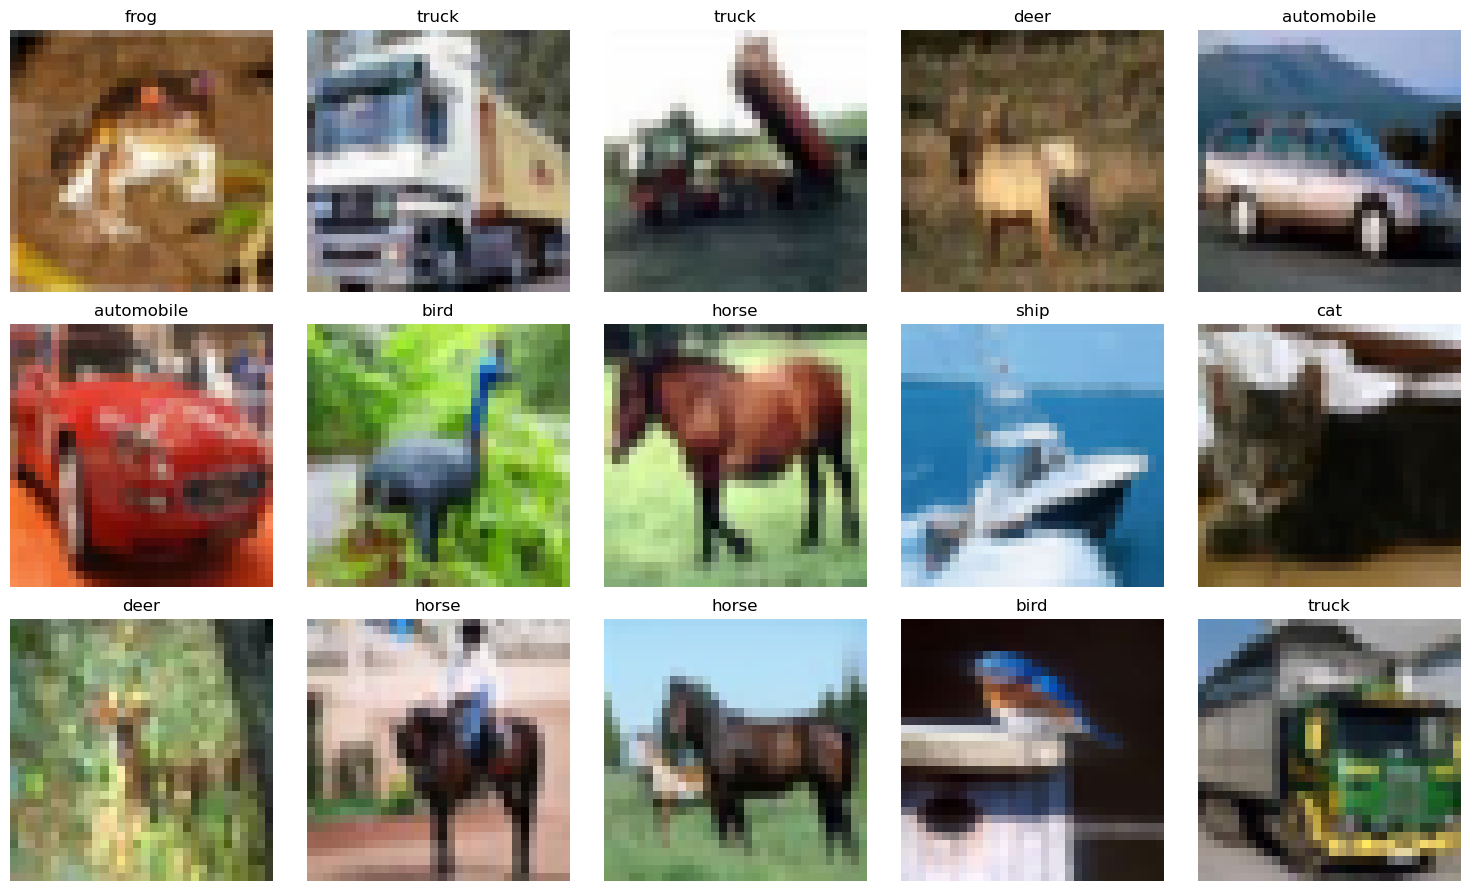

In [9]:
N_IMAGES = 15
images, labels = zip(*[(image, cifar10_train_data.dataset.targets[i])
                       for i, image in enumerate(images_without_labels[:N_IMAGES])])
classes = cifar10_train_data.dataset.classes
plot_images(images, labels, classes, normalize=True, rows=3, cols=5)


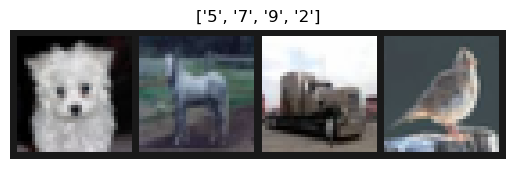

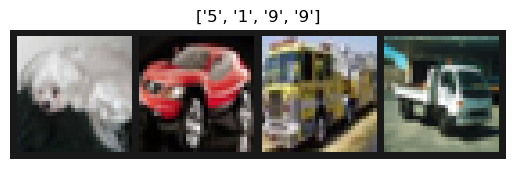

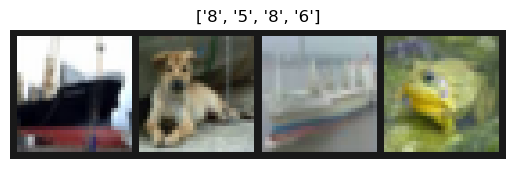

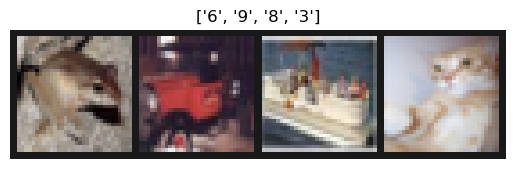

In [10]:
#In case you want to visualize by batches
def imshow(img, title):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.title(title)
    plt.axis('off')
    plt.show()

def show_batch_images(dataloader):
    images, labels = next(iter(dataloader))
    img = torchvision.utils.make_grid(images)
    imshow(normalize_image(img), title=[str(x.item()) for x in labels])

# Assuming you have defined your dataloader
trainloader = DataLoader(cifar10_train_data, batch_size=4, shuffle=True)

for i in range(4):
    show_batch_images(trainloader)


### Data PreProcessing

In [11]:
def imshow_masked(img):
  npimg = img.numpy()
  plt.figure(figsize = (3, 3))
  plt.axis('off')
  plt.imshow(np.transpose(npimg, (1,2,0)))
  plt.show()

# First version

### Function to create a hole on the image's center

torch.Size([4, 3, 32, 32])
torch.Size([4, 3, 32, 32])
torch.Size([4, 3, 32, 32])
torch.Size([4, 3, 32, 32])


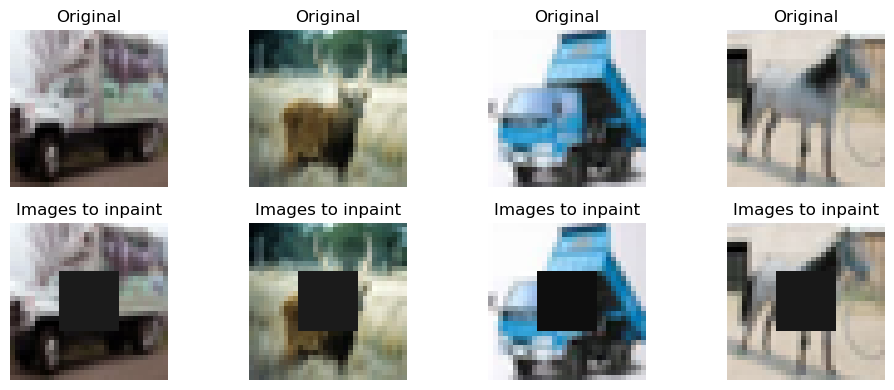

In [12]:
def create_image_with_hole(img, hole_size):
    batch_size, channels, height, width = img.shape
    new_img = img.clone()
    for i in range(batch_size):
        h_start = (height - hole_size) // 2
        w_start = (width - hole_size) // 2
        new_img[i, :, h_start:h_start + hole_size, w_start:w_start + hole_size] = 0.0
        print(new_img.shape)
    return new_img

# Size of the hole
hole_size = 12


images, labels = next(iter(trainloader))

images_with_holes = create_image_with_hole(images, hole_size)

num_images = 4
plt.figure(figsize=(10, 4))

for i in range(num_images):
    plt.subplot(2, num_images, i + 1)
    plt.imshow(normalize_image(images[i].permute(1, 2, 0)))
    plt.axis('off')
    plt.title('Original')

    plt.subplot(2, num_images, num_images + i + 1)
    plt.imshow(normalize_image(images_with_holes[i].permute(1, 2, 0)))
    plt.axis('off')
    plt.title('Images to inpaint')

plt.tight_layout()
plt.show()

# Create a Dataset that returns:
- Original image
- Image to inpaint
- Label (label is not required but I decided to keep the same structure of a regular dataset)

In [14]:
class CustomDataset(torchvision.datasets.CIFAR10):
    def __init__(self, path, hole_size, image_dims=(32, 32), n_channels=3, train=True):
        super().__init__(path, train=train, download=True)
        self.n_classes = 10
        self.image_dims = image_dims
        self.n_channels = n_channels
        self.resize = transforms.Resize(image_dims)
        self.to_tensor = transforms.ToTensor()
        self.hole_size = hole_size

    def __getitem__(self, idx):
        original_image, label = super().__getitem__(idx)
        original_image = self.to_tensor(original_image)  # Convert PIL Image to tensor
        #print("Original image shape:", original_image.shape)  # Debugging statement
        image_with_hole = self.create_image_with_hole(original_image, self.hole_size)
        #print("image with hole shape:", original_image.shape)
        return original_image, image_with_hole, label

    def create_image_with_hole(self, img, hole_size):
        try:
            batch_size, channels, height, width = img.shape
        except ValueError:  # In case there's no batch dimension
            channels, height, width = img.shape
            batch_size = 1  # Assume batch size of 1
        new_img = img.clone()

        h_start = (height - hole_size) // 2
        w_start = (width - hole_size) // 2

        # Create mask with the same shape as the image
        mask = torch.zeros_like(img)  # Fix 1

        mask[:, h_start:h_start + hole_size, w_start:w_start + hole_size] = 1.0
        # Ensure mask has the same shape for broadcasting (if needed)
        # mask = mask.expand_as(img)  # Fix 2 (uncomment if necessary)
        new_img = img * (1 - mask)  # Set masked region to 0 using element-wise multiplication

        return new_img

    def __len__(self):
        return len(self.data)

# Define the variables and load the data
hole_size = 8
custom_train_dataset = CustomDataset(cifar10_dir, hole_size)
custom_test_dataset = CustomDataset(cifar10_dir, hole_size, train=False)

# Ensure that custom_train_dataset and custom_test_dataset are valid instances of CustomDataset
print(len(custom_train_dataset))  # Print the size of the training set to verify
print(len(custom_test_dataset))
Batch_Size = 64

# Creating the dataloader for train and test data
custom_train_dataloader = DataLoader(custom_train_dataset, batch_size=Batch_Size, shuffle=True, drop_last=True)
custom_test_dataloader = DataLoader(custom_test_dataset, batch_size=Batch_Size, shuffle=True, drop_last=True)

# Because my machine doesn't have huge capacity I decided to work in a smaller portion of the data 
# Define the size of the subset
subset_size = 30000


small_custom_train_dataset = Subset(custom_train_dataset, list(range(subset_size)))
small_custom_train_dataloader = DataLoader(small_custom_train_dataset, batch_size=Batch_Size, shuffle=True, drop_last=True)

# Verify the data loading
try:
    images_original, images_with_hole, labels = next(iter(small_custom_train_dataloader))
    print("Data loaded successfully!")
except Exception as e:
    print("Error during data loading:", e)


Files already downloaded and verified
Files already downloaded and verified
50000
10000
Data loaded successfully!


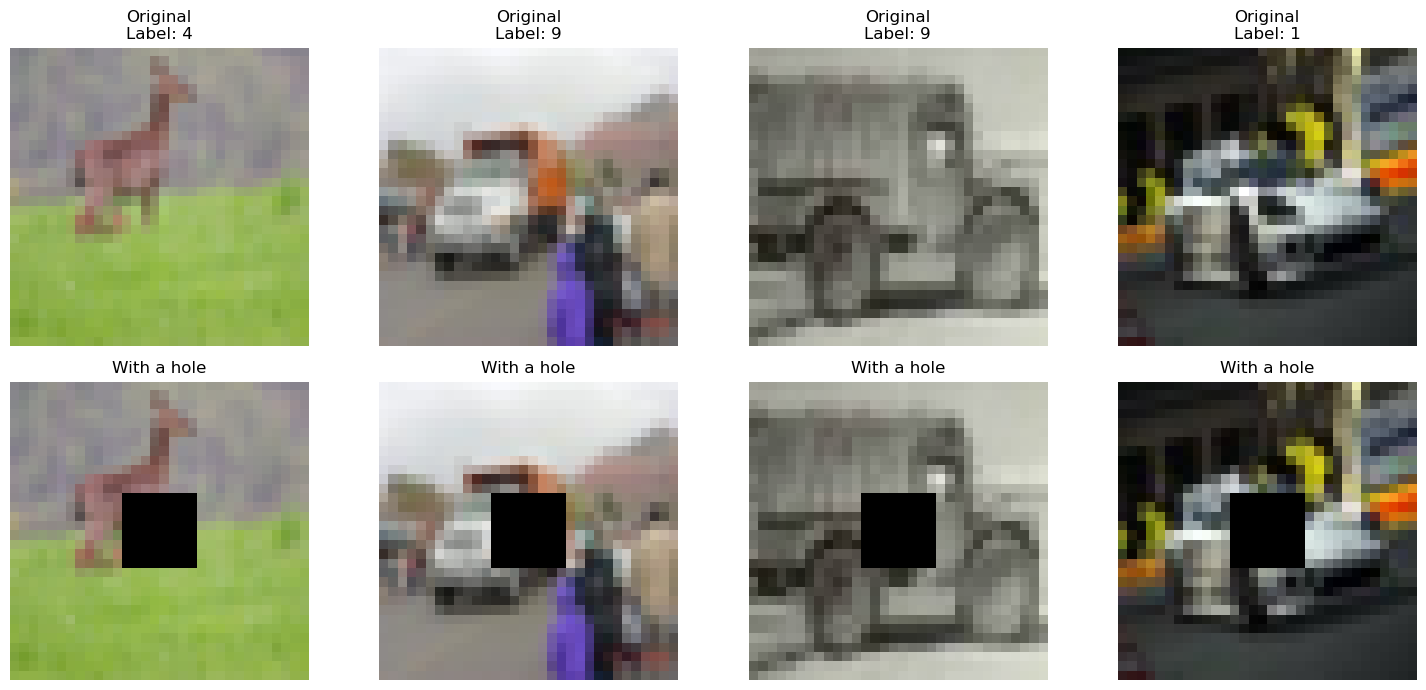

In [15]:

num_images = 4 # Get the actual number of images in the batch
plt.figure(figsize=(15, 7))

for i in range(num_images):
  plt.subplot(2, num_images, i + 1)
  plt.imshow(images_original[i].permute(1, 2, 0))
  plt.axis('off')
  plt.title(f'Original\nLabel: {labels[i]}')

  plt.subplot(2, num_images, num_images + i + 1)
  plt.imshow(images_with_hole[i].permute(1, 2, 0))
  plt.axis('off')
  plt.title('With a hole')

plt.tight_layout()
plt.show()

# Creating the mask where the autoencoder will work
 The idea behind this is that the AE updates its weights and optimizes its performace just by learning how to fill out the missing part and not the entire image

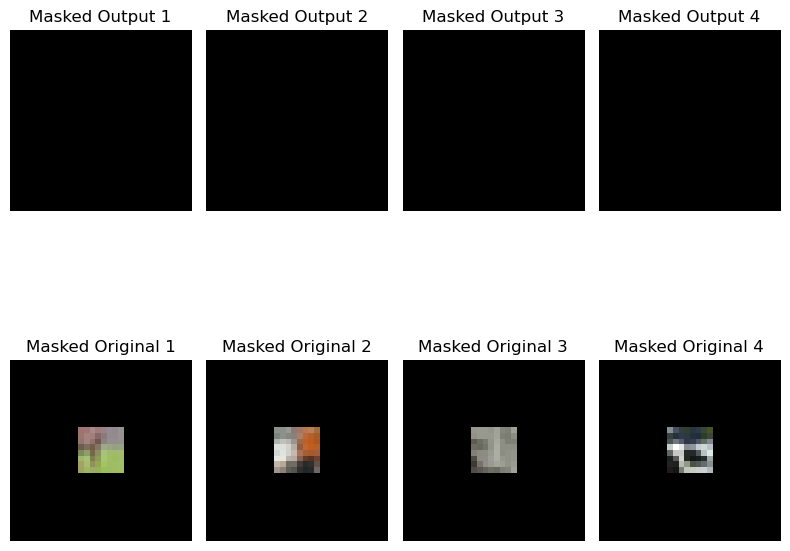

In [16]:
mask = torch.eq(images_with_hole, 0.0).all(dim=1, keepdim=True).float()

# Assuming outputs and images_original are tensors with shape (batch_size, channels, height, width)
masked_outputs = images_with_hole * mask
masked_images_original = images_original * mask

# Convert masked tensors to numpy arrays for visualization
masked_outputs_np = masked_outputs.detach().cpu().numpy()
masked_images_original_np = masked_images_original.detach().cpu().numpy()

# Plot the masked outputs and masked original images for comparison
fig, axes = plt.subplots(2, 4, figsize=(8, 8))
for i in range(4):
    axes[0, i].imshow(masked_outputs_np[i].transpose(1, 2, 0))
    axes[0, i].axis('off')
    axes[0, i].set_title(f'Masked Output {i + 1}')

    axes[1, i].imshow(masked_images_original_np[i].transpose(1, 2, 0))
    axes[1, i].axis('off')
    axes[1, i].set_title(f'Masked Original {i + 1}')

plt.tight_layout()
plt.show()


# Creating the Generator(AE)

In [19]:
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.shape[0], -1)

class Unflatten(nn.Module):

    def __init__(self, shape):
        super(Unflatten, self).__init__()
        self.shape = shape

    def forward(self, X):
        return X.view(-1, *self.shape)

class Generator(nn.Module):

    def __init__(self, im_channels):
        super(Generator, self).__init__()


        self.net = nn.Sequential(
            nn.Conv2d(im_channels, 64, 5, stride=1, padding=1),
            nn.LeakyReLU(0.1),
            nn.BatchNorm2d(64),

            nn.Conv2d(64, 128, 3, stride=2, padding=1),
            nn.LeakyReLU(0.1),
            nn.BatchNorm2d(128),
            nn.Conv2d(128, 128, 3, stride=1, padding=1),
            nn.LeakyReLU(0.1),
            nn.BatchNorm2d(128),


            nn.Conv2d(128, 256, 3, stride=2, padding=1),
            nn.LeakyReLU(0.1),
            nn.BatchNorm2d(256),
            nn.Conv2d(256, 256, 3, stride=1, padding=1),
            nn.LeakyReLU(0.1),
            nn.BatchNorm2d(256),
            nn.Conv2d(256, 256, 3, stride=1, padding=1),
            nn.LeakyReLU(0.1),
            nn.BatchNorm2d(256),

            nn.Conv2d(256, 256, 3, stride=1, padding=2, dilation=2),
            nn.LeakyReLU(0.1),
            nn.BatchNorm2d(256),
            nn.Conv2d(256, 256, 3, stride=1, padding=4, dilation=4),
            nn.LeakyReLU(0.1),
            nn.BatchNorm2d(256),
            nn.Conv2d(256, 256, 3, stride=1, padding=8, dilation=8),
            nn.LeakyReLU(0.1),
            nn.BatchNorm2d(256),
            nn.Conv2d(256, 256, 3, stride=1, padding=16, dilation=16),
            nn.LeakyReLU(0.1),
            nn.BatchNorm2d(256),

            nn.Conv2d(256, 256, 3, stride=1, padding=1),
            nn.LeakyReLU(0.1),
            nn.BatchNorm2d(256),
            nn.Conv2d(256, 256, 3, stride=1, padding=1),
            nn.LeakyReLU(0.1),
            nn.BatchNorm2d(256),

            nn.ConvTranspose2d(256, 128, 4, stride=2, padding=1),
            nn.LeakyReLU(0.1),
            nn.BatchNorm2d(128),
            nn.Conv2d(128, 128, 3, stride=1, padding=1),
            nn.LeakyReLU(0.1),
            nn.BatchNorm2d(128),

            nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1),
            nn.LeakyReLU(0.1),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 32, 3, stride=1, padding=1),
            nn.LeakyReLU(0.1),
            nn.BatchNorm2d(32),
            nn.Conv2d(32, im_channels, 3, stride=1, padding=1)

        )

    def forward(self, X):
        out = self.net(X)
        return out

# Train the aautoencoder first before we start with the adversarial game

In [21]:
# Define the autoencoder
autoencoder = Generator(im_channels=3)

# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(autoencoder.parameters(), lr=0.001)


autoencoder = autoencoder.to(device)


num_epochs = 30
print_loss_every = 100  # Print loss every 100 batches

for epoch in range(num_epochs):
    running_loss = 0.0
    for batch_idx, (images_original, images_with_hole, labels) in enumerate(small_custom_train_dataloader):
        images_original = images_original.to(device)
        images_with_hole = images_with_hole.to(device)

        # Forward pass
        outputs = autoencoder(images_with_hole)

        # Mask to isolate the hole region
        mask = torch.eq(images_with_hole, 0.0).all(dim=1, keepdim=True).float()

        # Compute the loss only for the hole region
        hole_loss = criterion(outputs * mask, images_original * mask)

        # Backward and optimize
        optimizer.zero_grad()
        hole_loss.backward()
        optimizer.step()

        running_loss += hole_loss.item()

        # Print loss every print_loss_every batches
        if (batch_idx + 1) % print_loss_every == 0:
            print(f"Epoch [{epoch + 1}/{num_epochs}], Batch [{batch_idx + 1}/{len(small_custom_train_dataloader)}], Loss: {hole_loss.item():.4f}")

    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {running_loss / len(small_custom_train_dataloader):.4f}")

print('Finished Training')


Epoch [1/30], Batch [100/468], Loss: 0.0020
Epoch [1/30], Batch [200/468], Loss: 0.0016
Epoch [1/30], Batch [300/468], Loss: 0.0015
Epoch [1/30], Batch [400/468], Loss: 0.0015
Epoch [1/30], Loss: 0.0026
Epoch [2/30], Batch [100/468], Loss: 0.0015
Epoch [2/30], Batch [200/468], Loss: 0.0014
Epoch [2/30], Batch [300/468], Loss: 0.0012
Epoch [2/30], Batch [400/468], Loss: 0.0015
Epoch [2/30], Loss: 0.0013
Epoch [3/30], Batch [100/468], Loss: 0.0012
Epoch [3/30], Batch [200/468], Loss: 0.0013
Epoch [3/30], Batch [300/468], Loss: 0.0013
Epoch [3/30], Batch [400/468], Loss: 0.0012
Epoch [3/30], Loss: 0.0012
Epoch [4/30], Batch [100/468], Loss: 0.0014
Epoch [4/30], Batch [200/468], Loss: 0.0010
Epoch [4/30], Batch [300/468], Loss: 0.0013
Epoch [4/30], Batch [400/468], Loss: 0.0012
Epoch [4/30], Loss: 0.0012
Epoch [5/30], Batch [100/468], Loss: 0.0011
Epoch [5/30], Batch [200/468], Loss: 0.0009
Epoch [5/30], Batch [300/468], Loss: 0.0010
Epoch [5/30], Batch [400/468], Loss: 0.0012
Epoch [5/30]

# Creation of a function for reconstruccion
-  The idea with this function is to take the image with hole in the center and fill the hole with the reconstruction part generated by the Generator(AE)

In [22]:
def fill_hole(image_with_hole, reconstructed_part, hole_size):
    """
    Fills the hole in an image with a reconstructed part.

    Args:
    image_with_hole (torch.Tensor): Image with a hole.
    reconstructed_part (torch.Tensor): Reconstructed part from the autoencoder.
    hole_size (int): Size of the hole.

    Returns:
    torch.Tensor: Image with the hole filled using the reconstructed part.
    """
    # Calculate the coordinates of the hole region based on the hole_size
    _, _, height, width = image_with_hole.shape
    h_start = (height - hole_size) // 2
    h_end = h_start + hole_size
    w_start = (width - hole_size) // 2
    w_end = w_start + hole_size

    # Fill the hole with the reconstructed part
    filled_image = image_with_hole.clone()
    filled_image[:, :, h_start:h_end, w_start:w_end] = reconstructed_part[:, :, h_start:h_end, w_start:w_end]

    return filled_image


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


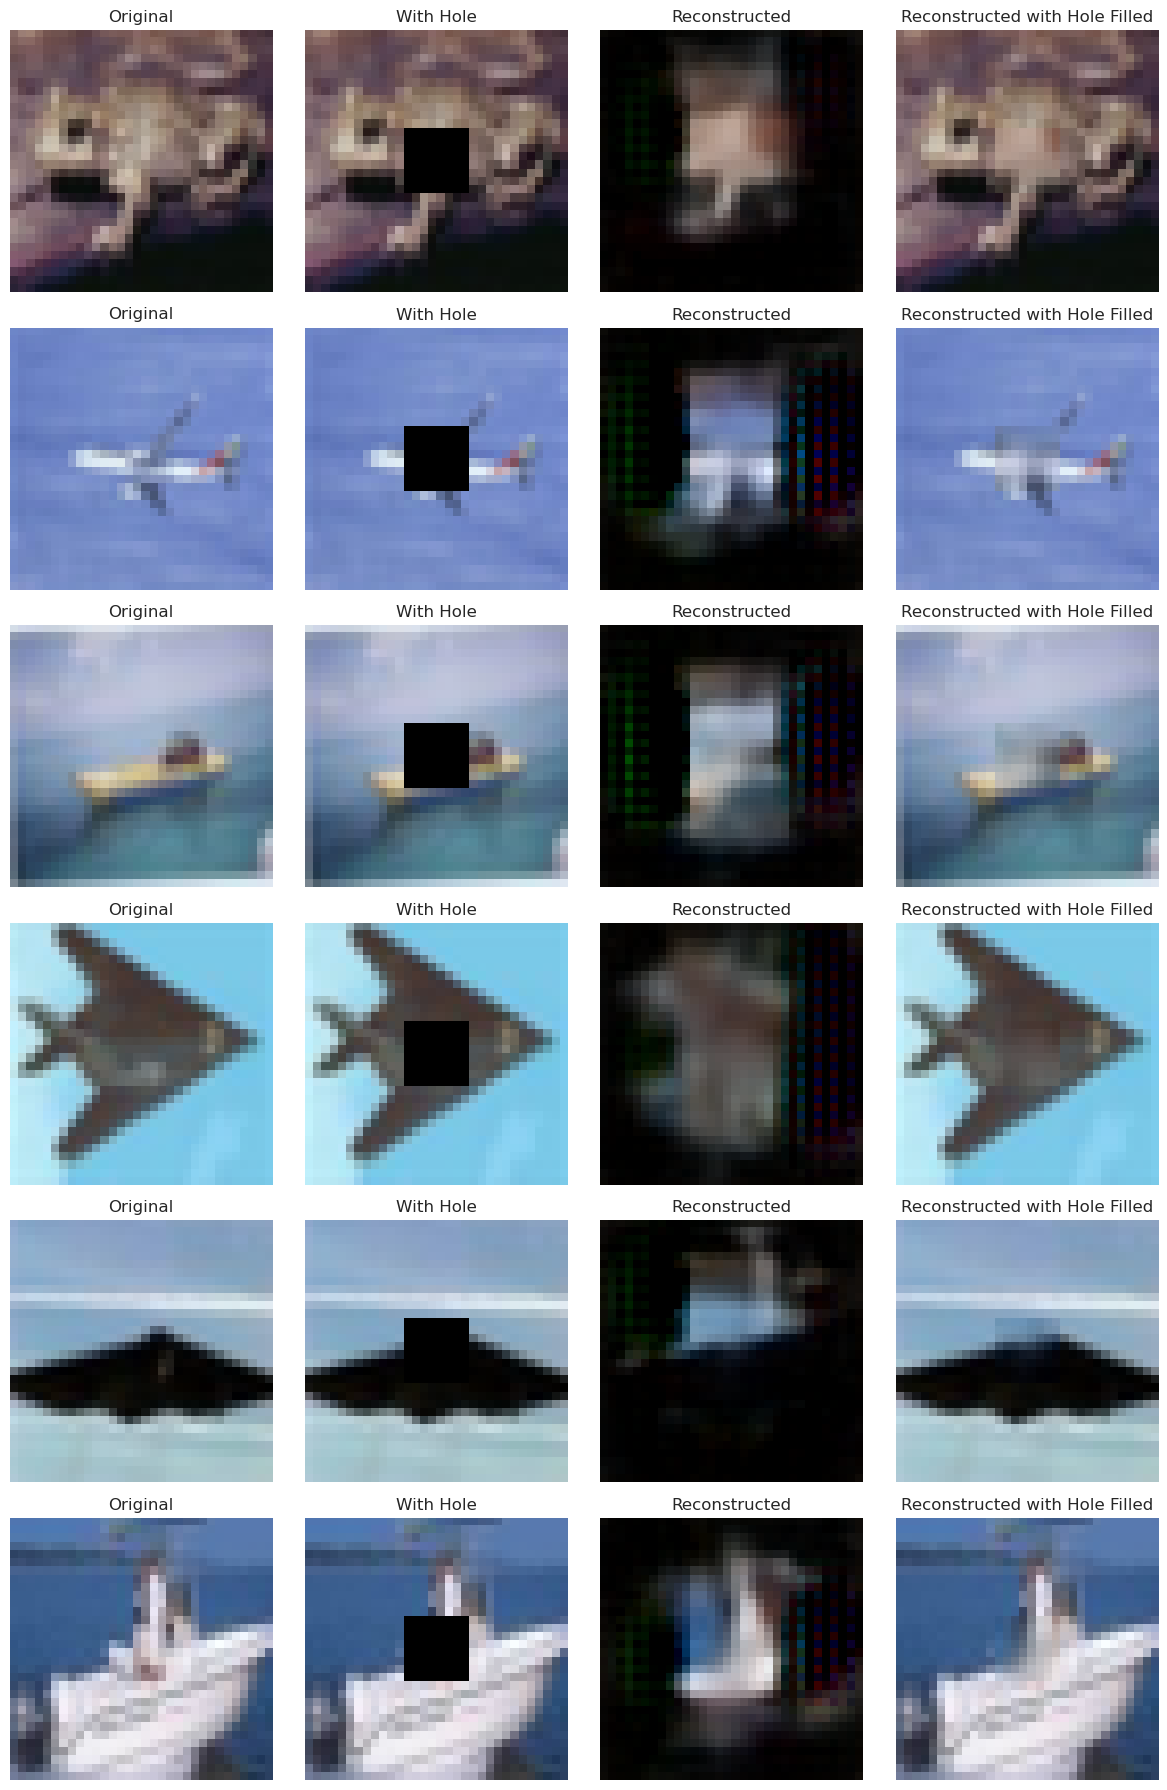

In [23]:
# Showing how the previous function works

# Get a batch of test images
images_original, images_with_hole, _ = next(iter(custom_test_dataloader))
images_original = images_original.to(device)
images_with_hole = images_with_hole.to(device)

# Get predictions from the autoencoder
with torch.no_grad():
    outputs = autoencoder(images_with_hole)

# Fill the holes in images_with_hole using the reconstructed parts
images_reconstructed = fill_hole(images_with_hole, outputs, hole_size=8)

# Convert tensors to NumPy arrays for visualization
images_original_np = images_original.cpu().numpy()
images_with_hole_np = images_with_hole.cpu().numpy()
outputs_np = outputs.cpu().numpy()
images_reconstructed_np = images_reconstructed.cpu().numpy()

# Visualize the images
num_images = 6
fig, axes = plt.subplots(num_images, 4, figsize=(12, 3 * num_images))
for i in range(num_images):
    # Original
    axes[i, 0].imshow(images_original_np[i].transpose(1, 2, 0))
    axes[i, 0].axis('off')
    axes[i, 0].set_title('Original')

    # With Hole
    axes[i, 1].imshow(images_with_hole_np[i].transpose(1, 2, 0))
    axes[i, 1].axis('off')
    axes[i, 1].set_title('With Hole')

    # Reconstructed without hole
    axes[i, 2].imshow(outputs_np[i].transpose(1, 2, 0))
    axes[i, 2].axis('off')
    axes[i, 2].set_title('Reconstructed')

    # Reconstructed with hole filled
    axes[i, 3].imshow(images_reconstructed_np[i].transpose(1, 2, 0))
    axes[i, 3].axis('off')
    axes[i, 3].set_title('Reconstructed with Hole Filled')

plt.tight_layout()
plt.show()



# Creating  the discriminator
The discriminator will consist in two components:
- Local discriminator
- Global discriminator

In [24]:
class LocalDiscriminator(nn.Module):
    def __init__(self, im_channels):
        super(LocalDiscriminator, self).__init__()

        self.net = nn.Sequential(
            nn.Conv2d(im_channels, 64, 5, stride=2, padding=2),
            nn.LeakyReLU(0.1),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 128, 5, stride=2, padding=2),
            nn.LeakyReLU(0.1),
            nn.BatchNorm2d(128),
            nn.Conv2d(128, 256, 5, stride=2, padding=2),
            nn.LeakyReLU(0.1),
            nn.BatchNorm2d(256),
            nn.Conv2d(256, 512, 5, stride=2, padding=2),
            nn.LeakyReLU(0.1),
            nn.BatchNorm2d(512),
            nn.Conv2d(512, 512, 5, stride=2, padding=2),
            nn.LeakyReLU(0.1),
            nn.BatchNorm2d(512),
            Flatten(),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.1),
            nn.BatchNorm1d(1024)
        )

    def forward(self, img, hole_size):
        # Create mask with the same shape as the image
        mask = torch.zeros_like(img)

        try:
            batch_size, channels, height, width = img.shape
        except ValueError:  # In case there's no batch dimension
            channels, height, width = img.shape
            batch_size = 1  # Assume batch size of 1

        h_start = (height - hole_size) // 2
        w_start = (width - hole_size) // 2

        mask[:, :, h_start:h_start + hole_size, w_start:w_start + hole_size] = 1.0
        masked_img = img * (1 - mask)

        out = self.net(masked_img)

        return out


In [25]:
class GlobalDiscriminator(nn.Module):
    def __init__(self, im_channels):
        super(GlobalDiscriminator, self).__init__()

        self.net = nn.Sequential(
            nn.Conv2d(im_channels, 64, 5, stride=2, padding=2),
            nn.LeakyReLU(0.1),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 128, 5, stride=2, padding=2),
            nn.LeakyReLU(0.1),
            nn.BatchNorm2d(128),
            nn.Conv2d(128, 256, 5, stride=2, padding=2),
            nn.LeakyReLU(0.1),
            nn.BatchNorm2d(256),
            nn.Conv2d(256, 512, 5, stride=2, padding=2),
            nn.LeakyReLU(0.1),
            nn.BatchNorm2d(512),
            nn.Conv2d(512, 512, 5, stride=2, padding=2),
            nn.LeakyReLU(0.1),
            nn.BatchNorm2d(512),
#             nn.Conv2d(512, 512, 5, stride=2, padding=2),
#             nn.LeakyReLU(0.1),
#             nn.BatchNorm2d(512),
            Flatten(),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.1),
            nn.BatchNorm1d(1024)
        )

    def forward(self, X):
        out = self.net(X)
        return out

## Complete Discriminator


In [26]:
class Discriminator(nn.Module):
    def __init__(self, local_d, global_d):
        super(Discriminator, self).__init__()
        self.local_discriminator = local_d
        self.global_discriminator = global_d
        self.fc = nn.Linear(2048, 1)

    def forward(self, X):
        local_ = self.local_discriminator(X,12)
        global_ = self.global_discriminator(X)
        concated = torch.cat((local_, global_), dim=1)
        out = self.fc(concated)

        return out

In [27]:
# Initialize your models
local_discriminator = LocalDiscriminator(im_channels=3).to(device)  # Assuming 3 input channels for CIFAR-10
global_discriminator = GlobalDiscriminator(im_channels=3).to(device)
discriminator = Discriminator(local_d=local_discriminator, global_d=global_discriminator).to(device)

 
# Define optimizer and loss function
lr_g = 0.0001
lr_d = 0.00001
w = 0.0005
betas = (0.5, 0.999)
optimizer_g = optim.Adam(autoencoder.parameters(), lr=lr_g, betas=betas)
optimizer_d = optim.Adam(discriminator.parameters(), lr=lr_d, betas=betas)
criterion = nn.BCEWithLogitsLoss()
criterion_2 = nn.MSELoss()
 
# Training loop
num_epochs = 30
for epoch in range(num_epochs):
    epoch_start_time = time.time()
    for batch_idx, (original_images, images_with_hole, labels) in enumerate(small_custom_train_dataloader):
        batch_size = original_images.size(0)
        original_images = original_images.to(device)
        images_with_hole = images_with_hole.to(device)
        # Generate fake images using the generator
        fake_images = autoencoder(images_with_hole)
        images_reconstructed = fill_hole(images_with_hole, fake_images, hole_size=8)
 
        # Train the discriminator
        optimizer_d.zero_grad()
        real_preds = discriminator(original_images)
        fake_preds = discriminator(images_reconstructed.detach())  # Detach to avoid generator gradients
        real_labels = torch.ones(batch_size, 1).to(device)  # Real images labeled as 1
        fake_labels = torch.zeros(batch_size, 1).to(device)  # Fake images labeled as 0
        d_real_loss = criterion(real_preds,real_labels)
        d_fake_loss = criterion(fake_preds,fake_labels)
        d_loss = (d_real_loss + d_fake_loss ) / 2
        d_loss.backward(retain_graph=True)
        optimizer_d.step()
 
        # Train the generator
        optimizer_g.zero_grad()
        fake_preds = discriminator(fake_images)
        g_loss = criterion(fake_preds,real_labels)  # Generator wants discriminator to output 1 for fakes
        mask = torch.eq(images_with_hole, 0.0).all(dim=1, keepdim=True).float()
        g_loss_2 = criterion_2(fake_images*mask,original_images*mask)
        g_loss_total = w * g_loss + g_loss_2
        g_loss_total.backward()
        optimizer_g.step()
 
        # Print training progress
        if batch_idx % 50 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Batch [{batch_idx+1}/{len(small_custom_train_dataloader)}], '
                  f'D_loss: {d_loss.item():.4f}, G_loss: {g_loss.item():.4f}')
        """if epoch % 2 == 0 or batch_idx == 0:
            original_image = original_images[0].cpu().detach().numpy().transpose(0, 2, 1)
            image_with_hole = images_with_hole[0].cpu().detach().numpy().transpose(0, 2, 1)
            fake_image = fake_images[0].cpu().detach().numpy().transpose(0, 2, 1)
 
              # Create a figure for plotting
            plt.figure(figsize=(12, 6))
 
              # Plot the original, image with hole, and generated image
            plt.subplot(1, 3, 1)
            plt.imshow(original_image)
            plt.title('Original Image')
            plt.axis('off')
 
            plt.subplot(1, 3, 2)
            plt.imshow(image_with_hole)
            plt.title('Image with Hole')
            plt.axis('off')
 
            plt.subplot(1, 3, 3)
            plt.imshow(fake_image)
            plt.title('Generated Image')
            plt.axis('off')
 
      # Show the plot (blocks execution until the figure is closed)
            plt.tight_layout()
            plt.show()"""
 
    # Print epoch-wise training time
    epoch_end_time = time.time()
    print(f'Epoch {epoch+1} completed in {epoch_end_time - epoch_start_time:.2f} seconds')
 
# Save models if needed
torch.save(autoencoder.state_dict(), 'Generator/generator.pth')
torch.save(discriminator.state_dict(), 'Discriminator/discriminator.pth')

Epoch [1/30], Batch [1/468], D_loss: 0.7329, G_loss: 0.7395
Epoch [1/30], Batch [51/468], D_loss: 0.7090, G_loss: 0.7220
Epoch [1/30], Batch [101/468], D_loss: 0.7082, G_loss: 0.7118
Epoch [1/30], Batch [151/468], D_loss: 0.7066, G_loss: 0.7051
Epoch [1/30], Batch [201/468], D_loss: 0.7018, G_loss: 0.7065
Epoch [1/30], Batch [251/468], D_loss: 0.6987, G_loss: 0.7042
Epoch [1/30], Batch [301/468], D_loss: 0.7015, G_loss: 0.7025
Epoch [1/30], Batch [351/468], D_loss: 0.6985, G_loss: 0.7006
Epoch [1/30], Batch [401/468], D_loss: 0.6997, G_loss: 0.7046
Epoch [1/30], Batch [451/468], D_loss: 0.6988, G_loss: 0.7057
Epoch 1 completed in 23.61 seconds
Epoch [2/30], Batch [1/468], D_loss: 0.6981, G_loss: 0.7059
Epoch [2/30], Batch [51/468], D_loss: 0.6971, G_loss: 0.7030
Epoch [2/30], Batch [101/468], D_loss: 0.6984, G_loss: 0.7043
Epoch [2/30], Batch [151/468], D_loss: 0.6962, G_loss: 0.7001
Epoch [2/30], Batch [201/468], D_loss: 0.6965, G_loss: 0.7020
Epoch [2/30], Batch [251/468], D_loss: 0.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


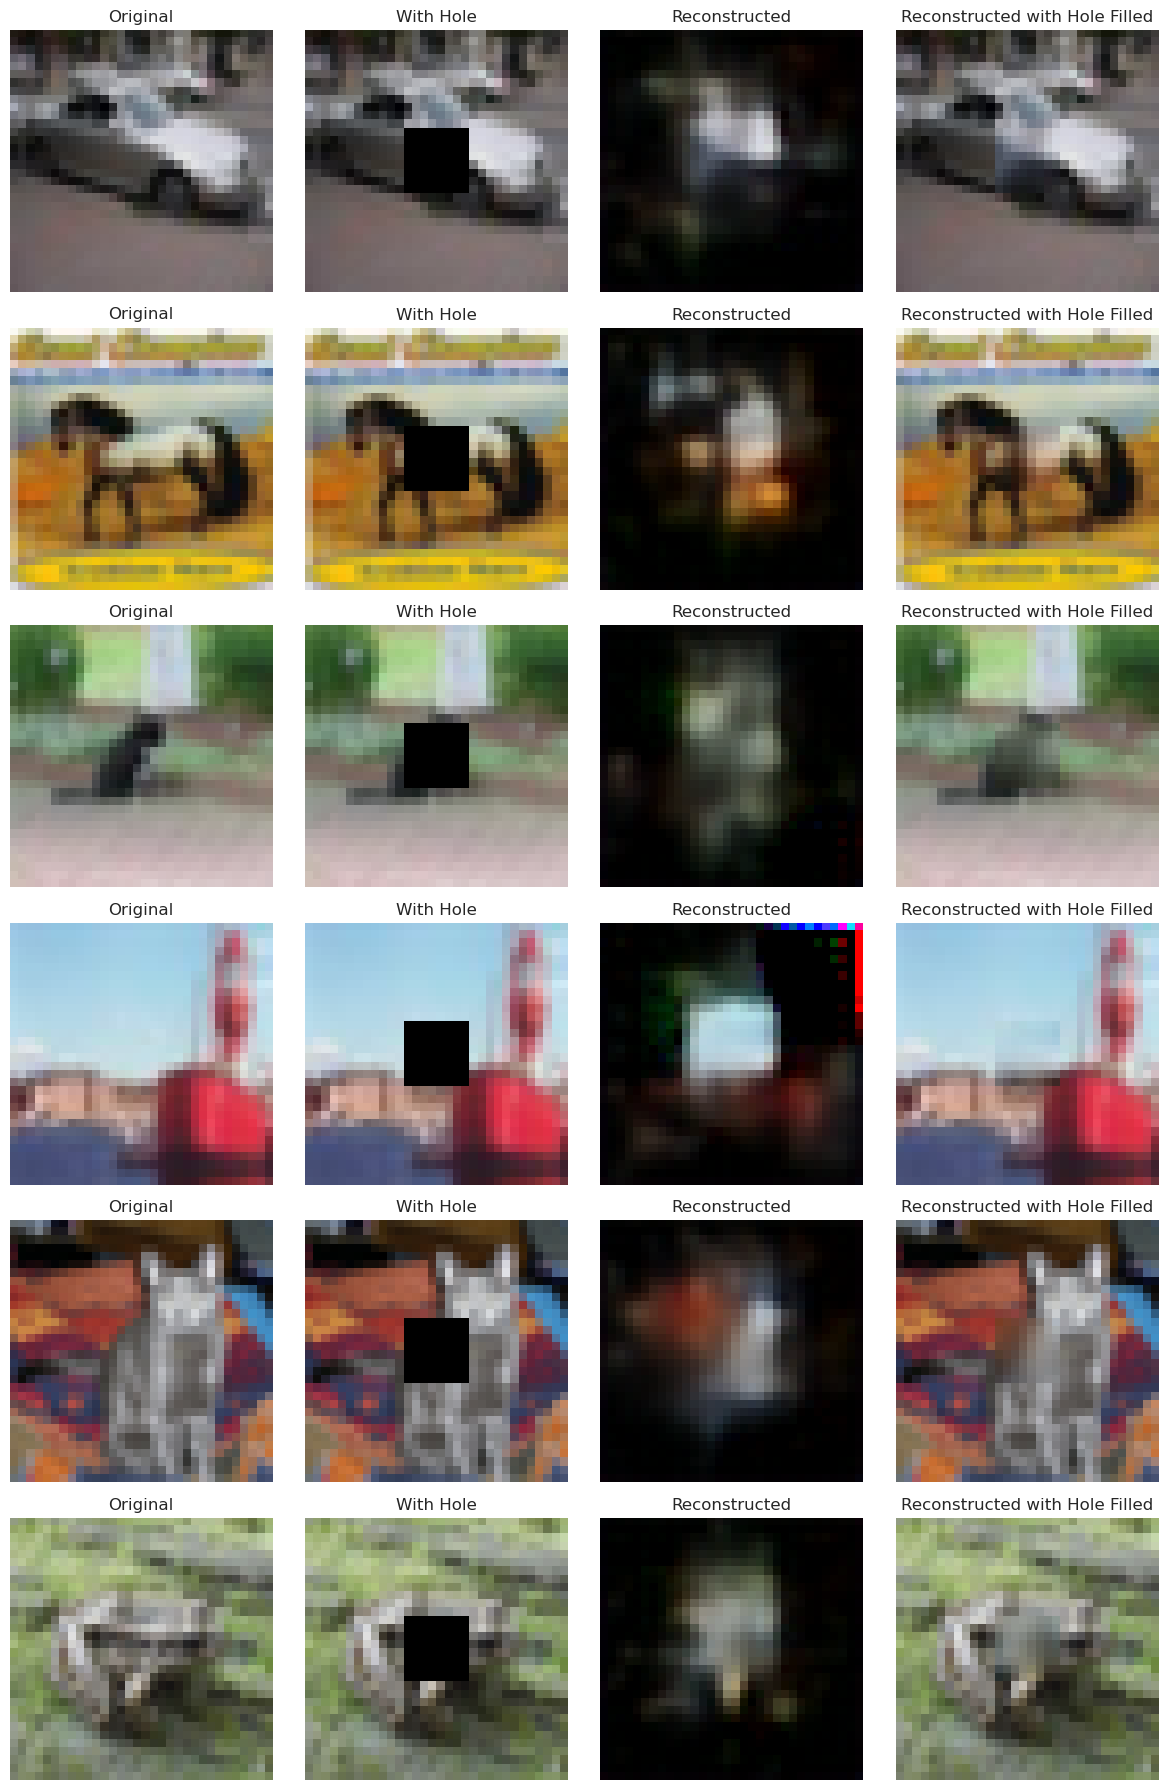

In [33]:
# Get a batch of test images
images_original, images_with_hole, _ = next(iter(custom_test_dataloader))
images_original = images_original.to(device)
images_with_hole = images_with_hole.to(device)

# Get predictions from the autoencoder
with torch.no_grad():
    outputs = autoencoder(images_with_hole)

# Fill the holes in images_with_hole using the reconstructed parts
images_reconstructed = fill_hole(images_with_hole, outputs, hole_size=8)

# Convert tensors to NumPy arrays for visualization
images_original_np = images_original.cpu().numpy()
images_with_hole_np = images_with_hole.cpu().numpy()
outputs_np = outputs.cpu().numpy()
images_reconstructed_np = images_reconstructed.cpu().numpy()

# Visualize the images
num_images = 6
fig, axes = plt.subplots(num_images, 4, figsize=(12, 3 * num_images))
for i in range(num_images):
    # Original
    axes[i, 0].imshow(images_original_np[i].transpose(1, 2, 0))
    axes[i, 0].axis('off')
    axes[i, 0].set_title('Original')

    # With Hole
    axes[i, 1].imshow(images_with_hole_np[i].transpose(1, 2, 0))
    axes[i, 1].axis('off')
    axes[i, 1].set_title('With Hole')

    # Reconstructed without hole
    axes[i, 2].imshow(outputs_np[i].transpose(1, 2, 0))
    axes[i, 2].axis('off')
    axes[i, 2].set_title('Reconstructed')

    # Reconstructed with hole filled
    axes[i, 3].imshow(images_reconstructed_np[i].transpose(1, 2, 0))
    axes[i, 3].axis('off')
    axes[i, 3].set_title('Reconstructed with Hole Filled')

plt.tight_layout()
plt.show()



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


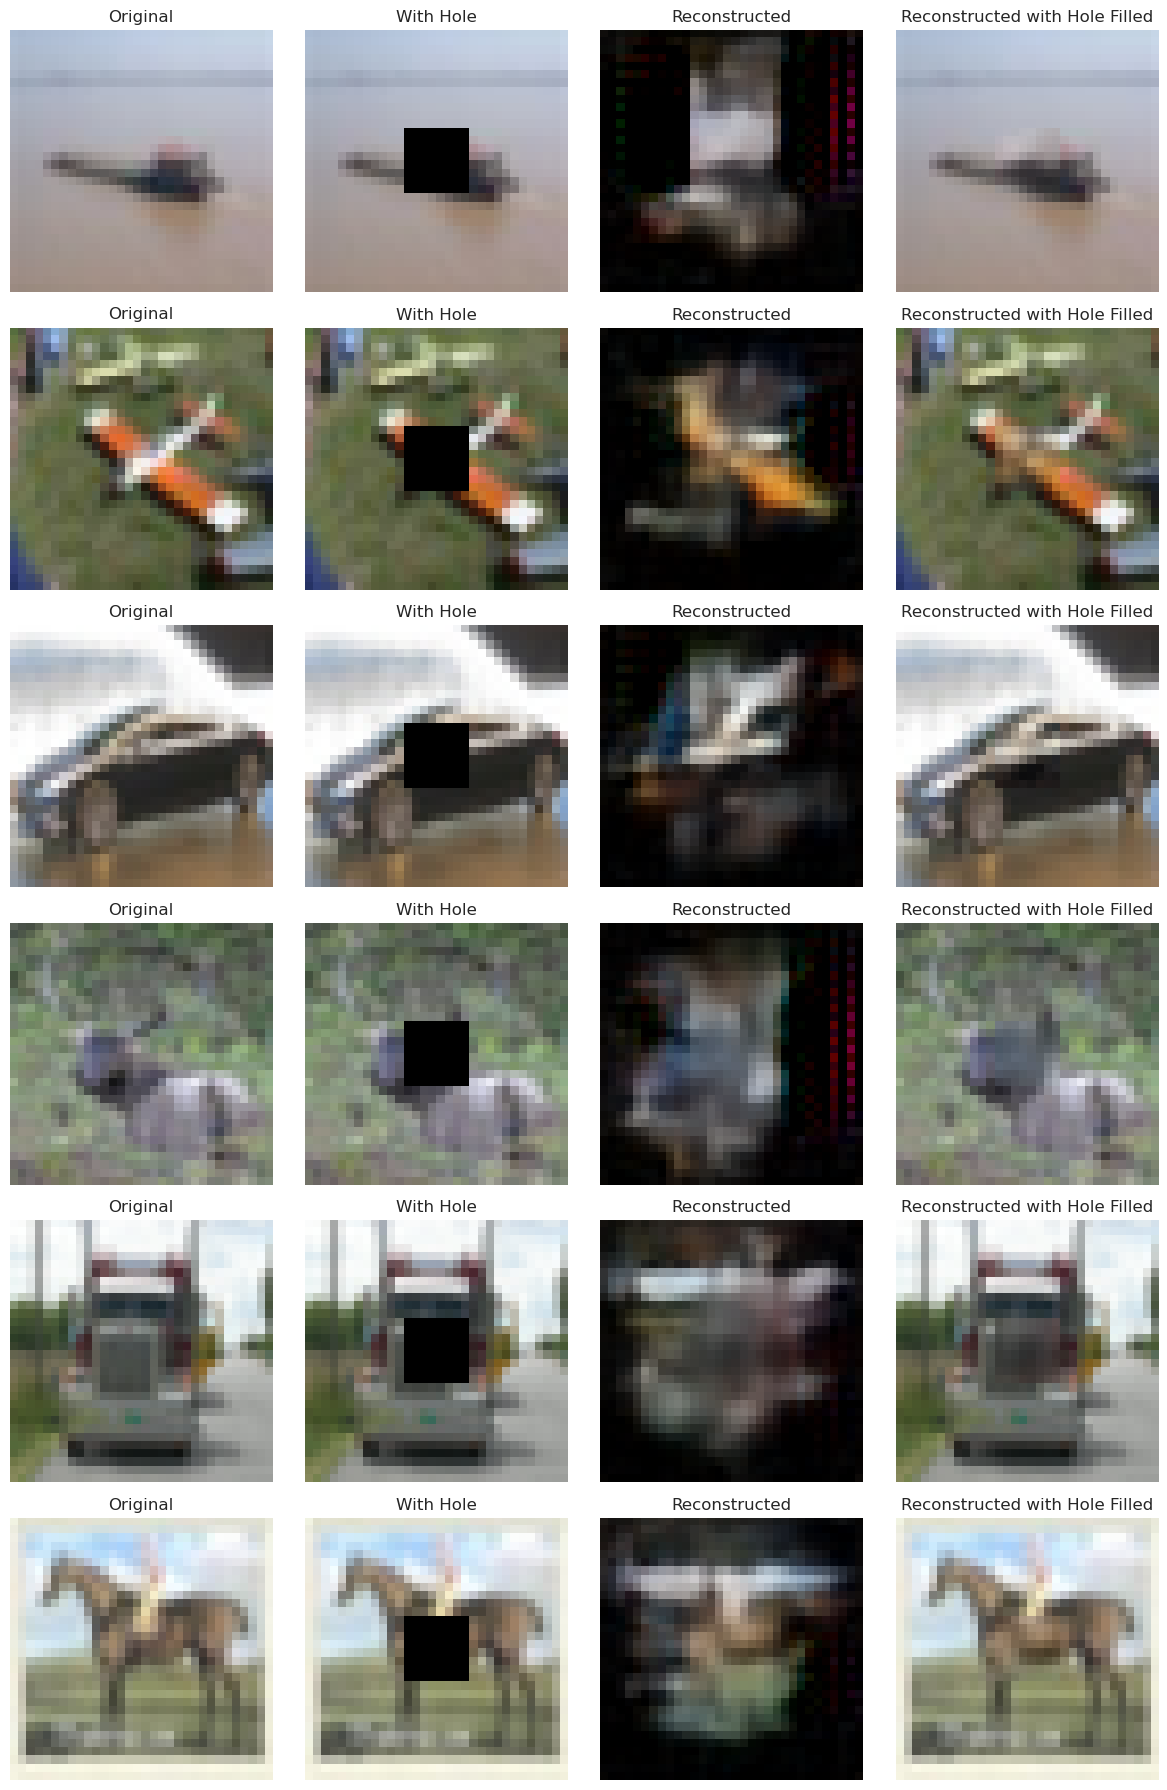

In [29]:
# Get a batch of test images
images_original, images_with_hole, _ = next(iter(custom_test_dataloader))
images_original = images_original.to(device)
images_with_hole = images_with_hole.to(device)

# Get predictions from the autoencoder
with torch.no_grad():
    outputs = autoencoder(images_with_hole)

# Fill the holes in images_with_hole using the reconstructed parts
images_reconstructed = fill_hole(images_with_hole, outputs, hole_size=8)

# Convert tensors to NumPy arrays for visualization
images_original_np = images_original.cpu().numpy()
images_with_hole_np = images_with_hole.cpu().numpy()
outputs_np = outputs.cpu().numpy()
images_reconstructed_np = images_reconstructed.cpu().numpy()

# Visualize the images
num_images = 6
fig, axes = plt.subplots(num_images, 4, figsize=(12, 3 * num_images))
for i in range(num_images):
    # Original
    axes[i, 0].imshow(images_original_np[i].transpose(1, 2, 0))
    axes[i, 0].axis('off')
    axes[i, 0].set_title('Original')

    # With Hole
    axes[i, 1].imshow(images_with_hole_np[i].transpose(1, 2, 0))
    axes[i, 1].axis('off')
    axes[i, 1].set_title('With Hole')

    # Reconstructed without hole
    axes[i, 2].imshow(outputs_np[i].transpose(1, 2, 0))
    axes[i, 2].axis('off')
    axes[i, 2].set_title('Reconstructed')

    # Reconstructed with hole filled
    axes[i, 3].imshow(images_reconstructed_np[i].transpose(1, 2, 0))
    axes[i, 3].axis('off')
    axes[i, 3].set_title('Reconstructed with Hole Filled')

plt.tight_layout()
plt.show()

# Second version

### Function to create a hole in a random position

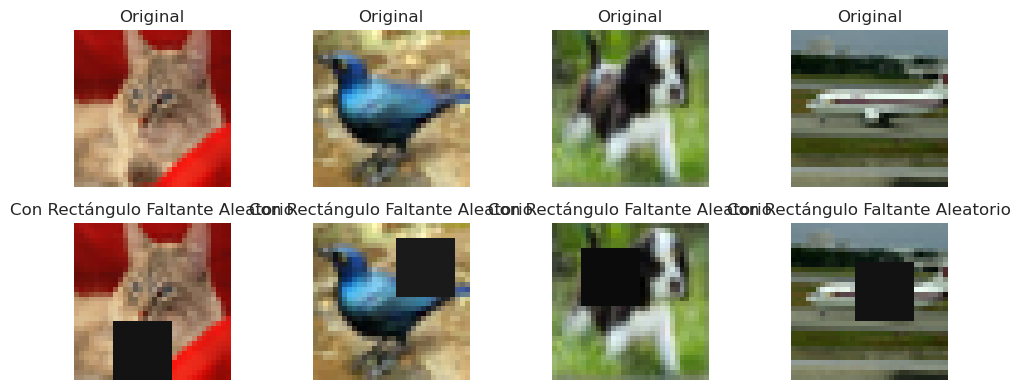

In [14]:
def create_image_with_random_hole(img, hole_size):
    batch_size, channels, height, width = img.shape
    new_img = img.clone()
    for i in range(batch_size):
        h_start = random.randint(0, height - hole_size)
        w_start = random.randint(0, width - hole_size)
        new_img[i, :, h_start:h_start + hole_size, w_start:w_start + hole_size] = 0.0
    return new_img

hole_size = 12

images, labels = next(iter(trainloader))

images_with_random_holes = create_image_with_random_hole(images, hole_size)

num_images = 4
plt.figure(figsize=(10, 4))

for i in range(num_images):
    plt.subplot(2, num_images, i + 1)
    plt.imshow(normalize_image(images[i].permute(1, 2, 0)))  # Cambiar el orden de dimensiones para mostrar la imagen
    plt.axis('off')
    plt.title('Original')

    plt.subplot(2, num_images, num_images + i + 1)
    plt.imshow(normalize_image(images_with_random_holes[i].permute(1, 2, 0)))  # Cambiar el orden de dimensiones para mostrar la imagen
    plt.axis('off')
    plt.title('Con Rectángulo Faltante Aleatorio')

plt.tight_layout()
plt.show()